In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
current_directory = os.getcwd()
print(current_directory)
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

D:\GitHub\keras_learning\training_project\Natural Language Processing with Disaster Tweets


FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

In [38]:
print(train.columns)
train.head(5)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [39]:
test.sample(5)

,id,keyword,location,text
2649,8849,smoke,Roseland,@wizkhalifa smoke ??so much you don't gotta do...
620,2021,casualties,NaN,More women children casualties of Afghan viole...
3185,10577,windstorm,NaN,Texas Seeks Comment on Rules for Changes to Wi...
384,1248,blood,The Land of Pleasant Living,Bitch I'm a monster no good blood sucker
2271,7574,outbreak,"Nashville, Tennessee",Families to sue over Legionnaires: More than 4...


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [41]:
train_label = train.target.to_numpy()

In [42]:
y_train = train_label.reshape(-1)

In [43]:
train.drop(['id', 'keyword', 'location', 'target'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [44]:
train = train.to_numpy()
test = test.to_numpy()
X_train = train.reshape(-1)
X_test = test.reshape(-1)

In [45]:
print(X_train[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


## Normalization

In [46]:
import re
import string

def clean_tweet(tweet):

  #apostrophe
  tweet = re.sub(r'\x89Ûª', "'", tweet)
  tweet = re.sub(r'\x89Û÷', "'", tweet)

  #quotation
  tweet = re.sub(r'\x89ÛÏ', '"', tweet)
  tweet = re.sub(r'\x89Û\x9d', '"', tweet)

  #hyphen
  tweet = re.sub(r'\x89ÛÒ', '-', tweet)
  tweet = re.sub(r'\x89ÛÓ', '—', tweet)

  #euro
  tweet = re.sub(r'\x89âÂ', '€', tweet)

  #ellipsis
  tweet = re.sub(r'\x89Û_', '...', tweet)

  #amp
  tweet = re.sub(r'&', 'and', tweet)


  #bullet
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r'\x89Û¢', '', tweet)


  #no idea
  tweet = re.sub(r'\x89ã¢', '', tweet)
  tweet = re.sub(r"å_", "", tweet)


  #other
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", "3 million ", tweet)
  tweet = re.sub(r"åÀ", "", tweet)

  return tweet

def find_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')

  return url.findall(text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [47]:
def custom_standardization(input_data):
    r = clean_tweet(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = str.lower(r)
    return r

In [48]:
all_tweets = np.append(X_train, X_test)
def normalization(tweets):
    result = []
    for tweet in tweets:
        result.append(custom_standardization(tweet))
    return result

all_tweets = normalization(all_tweets)

In [49]:
# Model constants.
max_features = 20000
embedding_dim = 128
max_len = 500

## Tokenizer

In [50]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


In [51]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

## Loading models from TensorFlow Hub

In [52]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [53]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [54]:
all_tweets[0]

'our deeds are the reason of this #earthquake may allah forgive us all'

In [55]:
text_test = [all_tweets[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2256 15616  2024  1996  3114  1997  2023  1001  8372  2089 16455]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [56]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [57]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.8805216   0.8859627   0.02324418  0.346368    0.22012922  0.54245526
  0.9885263  -0.97328836 -0.44442183 -0.9884246   0.15767492 -0.986612  ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.04167694 -0.5527509  -0.39509642 ... -0.70465016  0.02087686
   1.359921  ]
 [-0.02986103  0.20303433 -0.74737203 ... -0.62841207 -0.22217065
   0.3419122 ]
 [-0.5731175  -0.8957891  -0.31389296 ... -0.291898    0.57954067
   1.3041601 ]
 ...
 [-0.5826614  -0.20335156 -0.49349603 ...  0.0648779  -0.07748289
   0.6788095 ]
 [-0.5776433  -0.11583461 -0.697853   ... -0.740928   -0.07606461
   0.75299025]
 [ 0.17244081 -0.7967615   0.7065049  ...  0.7029192   1.3446757
   0.69009024]]


In [58]:
import tensorflow as tf

In [59]:
## Spilt Data to train and validation
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [60]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache()
train_ds = train_ds.batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
val_ds = val_ds.batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [61]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [62]:
from keras.layers import *
from keras.models import Model
from keras import losses
from keras.metrics import BinaryAccuracy

def build_classifier_model():
    text_input = Input(shape=(), dtype='string', name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)

    model = Model(text_input, net)

    # Compile the model with binary crossentropy loss and an adam optimizer.

    model.compile(loss=losses.binary_crossentropy, optimizer=optimizer, metrics=[BinaryAccuracy()])

    return model

In [63]:
import tensorflow as tf
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(bert_raw_result)

In [64]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

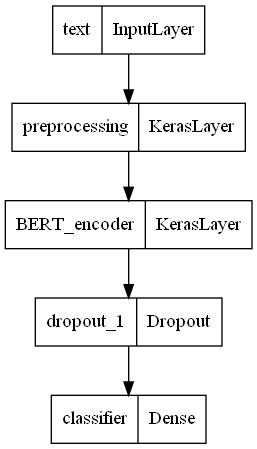

In [65]:
tf.keras.utils.plot_model(classifier_model)

In [66]:
from keras.callbacks import *

lr = ReduceLROnPlateau(monitor="val_binary_accuracy", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_binary_accuracy',mode='max', patience=10, verbose=False,restore_best_weights=True)

history = classifier_model.fit(
                            x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs,
                            callbacks=[es,lr]
        )

Epoch 1/5
191/191 [==============================] - ETA: 0s - loss: 0.5377 - binary_accuracy: 0.7286

TypeError: unsupported operand type(s) for *: 'WarmUp' and 'int'

In [ ]:
loss, accuracy = classifier_model.evaluate(X_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
def plot_hist(history_dict):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    return

In [ ]:
plot_hist(hist=history)

## Predict test data

In [ ]:
y_pred = classifier_model.predict(X_test).squeeze()

In [ ]:
sub_data = pd.read_csv("data/sample_submission.csv")

In [ ]:
sub_data.target = (y_pred > 0.5).astype(int)

In [ ]:
sub_data

In [ ]:
sub_data.to_csv('submission.csv', index=False)